<a href="https://colab.research.google.com/github/Anjalichimnani/EVA4/blob/master/Assignment_10/EVA_S10_CIFAR10_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
#https://modelzoo.co/model/data-augmentation-and-sampling-for-pytorch

!google-drive-ocamlfuse -cc

/bin/bash: google-drive-ocamlfuse: command not found


In [2]:
!pip install pytorch-gradcam
!pip install albumentations
!pip install torch-lr-finder -v --global-option="amp"

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-77p0f0to
Created temporary directory: /tmp/pip-req-tracker-2bigobpg
Created requirements tracker '/tmp/pip-req-tracker-2bigobpg'
Created temporary directory: /tmp/pip-install-vsbu0zal
Cleaning up...
Removed build tracker '/tmp/pip-req-tracker-2bigobpg'


In [3]:
# Mouting Drive location where all the modularized code is present
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Mapping the Drive location so that the files are loaded
import sys
sys.path.append('/content/drive/My Drive/EVA4/Assignment_10/files/')
from imports.imports_eva import *

from models import get_model as gm

from dataloaders import get_train_test as tt
from dataloaders import train_test_loader as ttl
from dataloaders import train_test_def as ttd
from dataloaders import albumentation_transform as albumentation_transform

from visualization import grad_cam as grad_cam

from optimizer.torch_lr_finder.lr_finder import LRFinder

from visualization import misclassified_images as misclassified

  pip install torch-lr-finder -v --global-option="amp"


CUDA Available? True


In [5]:
# Test whether CUDA is available or not and the Device being used
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
0
Tesla T4


In [6]:
trainloader, testloader = albumentation_transform.train_test_loaders(128) 

Files already downloaded and verified
Files already downloaded and verified
Train Images count 50000
Test Images count 10000


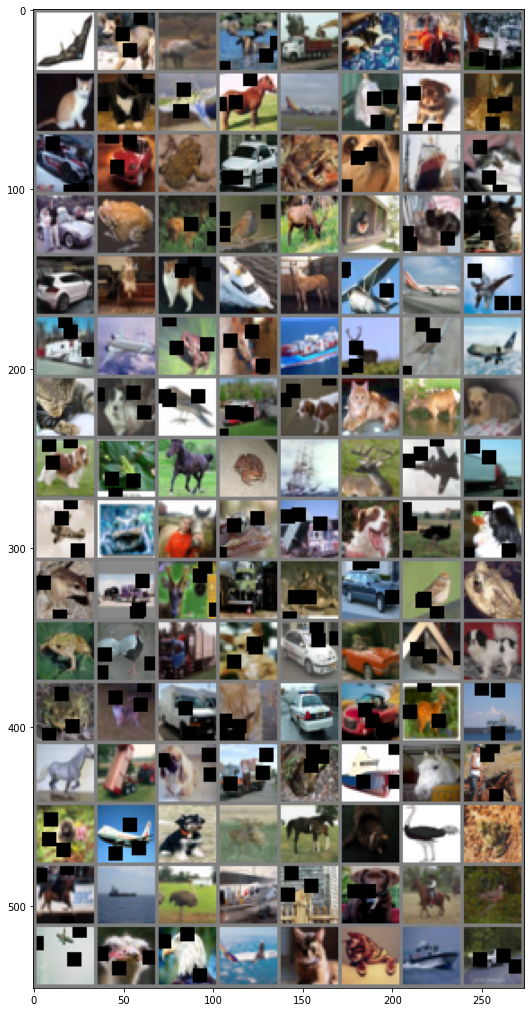

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(28,18))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [8]:
# Check the Model Summary - Parameters used and memory consumed. 
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = gm.get_model_instance().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print (classes)

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Learning rate search finished. See the graph with {finder_name}.plot()


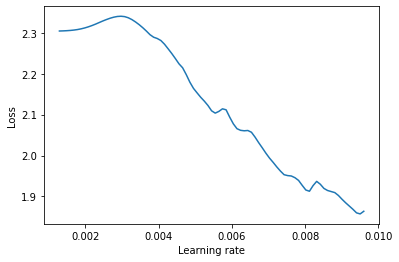

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader, start_lr = 0.0001, end_lr=0.01, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)

In [0]:
# Run the Model and obtain the Train/Test Accuracy and Loss
#   Dropout Rate used is 0.1 which is passed as parameter to the model
#   Regulariation can be added to the code
train_losses = []
test_losses = []
train_acc = []
test_acc = []

model = gm.get_model_instance().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.009, momentum=0.9, weight_decay=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0, verbose=True)

In [11]:


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    a,b = ttd.train(model, device, trainloader, optimizer, epoch)
    train_losses.extend(a)
    train_acc.extend(b)
    c,d = ttd.test(model, device, testloader)
    test_losses.extend(c)
    test_acc.extend(d)
    scheduler.step(b[epoch])
    print('')

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 5735/10000 (57.35%)


EPOCH: 2


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 7060/10000 (70.60%)


EPOCH: 3


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 6891/10000 (68.91%)


EPOCH: 4


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 6885/10000 (68.85%)


EPOCH: 5


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6943/10000 (69.43%)


EPOCH: 6


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7543/10000 (75.43%)

Epoch     6: reducing learning rate of group 0 to 9.0000e-04.

EPOCH: 7


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8760/10000 (87.60%)


EPOCH: 8


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8818/10000 (88.18%)


EPOCH: 9


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8869/10000 (88.69%)


EPOCH: 10


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8873/10000 (88.73%)


EPOCH: 11


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8929/10000 (89.29%)


EPOCH: 12


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8827/10000 (88.27%)

Epoch    12: reducing learning rate of group 0 to 9.0000e-05.

EPOCH: 13


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9068/10000 (90.68%)

Epoch    13: reducing learning rate of group 0 to 9.0000e-06.

EPOCH: 14


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9055/10000 (90.55%)


EPOCH: 15


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9061/10000 (90.61%)

Epoch    15: reducing learning rate of group 0 to 9.0000e-07.

EPOCH: 16


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9064/10000 (90.64%)

Epoch    16: reducing learning rate of group 0 to 9.0000e-08.

EPOCH: 17


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9061/10000 (90.61%)


EPOCH: 18


Loss=0.177 Batch_id=49 Accuracy=95.02:  13%|█▎        | 50/391 [00:08<00:52,  6.43it/s]

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Test Accuracy')

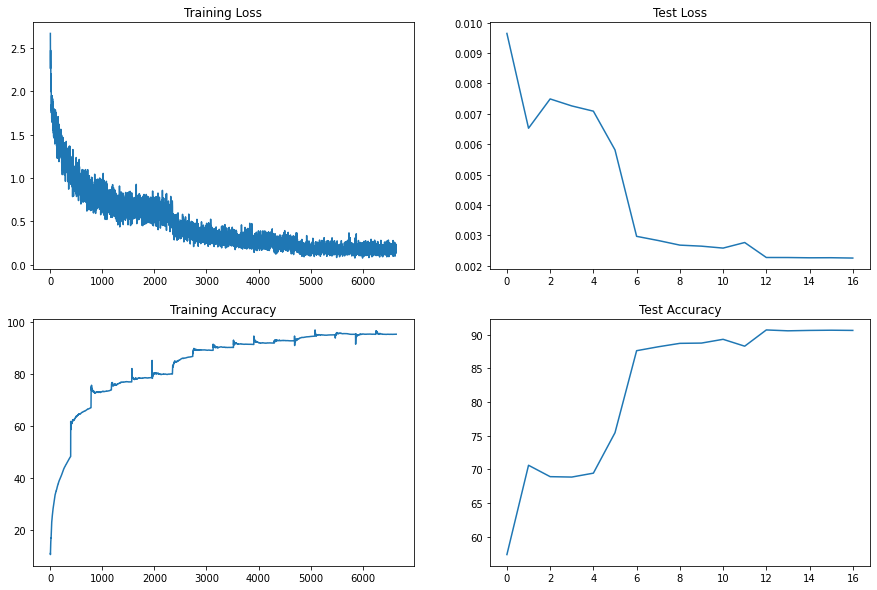

In [13]:
# Visualize the Training/Test Accuracy/Loss using Matplotlib

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
def test_misclassified(model, device, testloader, nimage = 25):
    model.eval()
    images = []
    preds = []
    actual = []
    #test_loss = 0
    #correct = 0
    count = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True).view_as(target)  # get the index of the max log-probability
            #correct += pred.eq(target.view_as(pred)).sum().item()
            for a,b,c in zip(data, target, pred):
              if b!=c:
                a = a.cpu().numpy()
                b = b.cpu().numpy()
                c = c.cpu().numpy()
                a = (a*0.5)+0.5
                images.append(a)
                preds.append(c)
                actual.append(b)
                count += 1
              if count == nimage:
                return images, actual, preds

In [0]:
def plot_images(images,actual,preds,nimage=25):
  fig = plt.figure(figsize=(15,18))
  for i in range(nimage):
    ax = fig.add_subplot(5,5,i+1)
    ax.imshow(np.rollaxis(images[i],0,3).squeeze(),cmap='gray')
    #ax.axis('off')
    ax.set_title("Actual: " + str(actual[i]) + " predicted:  " + str(preds[i]))
  plt.show()

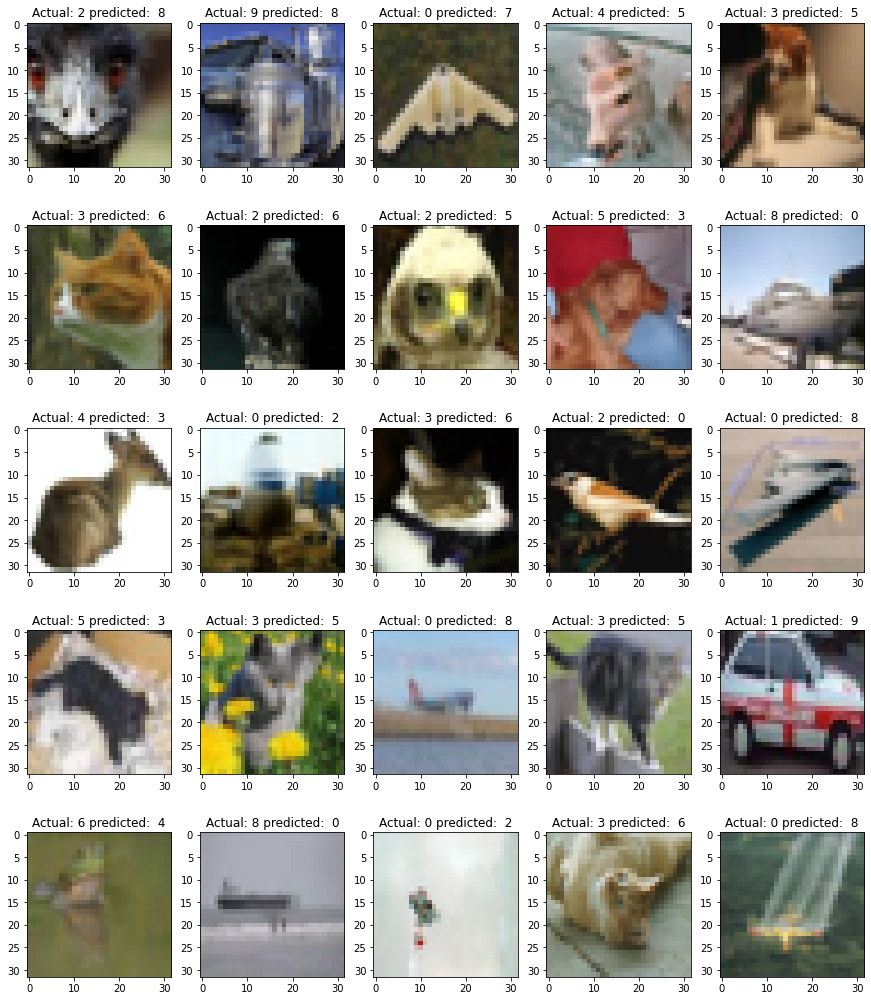

In [28]:
images, actuals, preds = test_misclassified(model,device,testloader)
plot_images(images,actuals,preds)

In [0]:
#Load the Images for GradCam

raw_image_samples = []
image_samples = []

image_sample_url = "https://wallpapercave.com/wp/LGb0XgC.jpg"

image_sample = Image.open(urllib.request.urlopen(image_sample_url))
image_sample = np.uint8(cv2.resize(np.asarray(image_sample), (32,32)))
raw_image_sample = image_sample

image_sample = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    )(image_sample[..., ::-1].copy())

raw_image_samples.append(raw_image_sample)
image_samples.append(image_sample)

#print (image_sample)
image_samples = torch.stack(image_samples).to(device)


In [0]:
## Run the GradCam Implementation
output_dir = "./results"


def save_gradient(filename, gradient):
  gradient = gradient.cpu().numpy().transpose(1, 2, 0)
  gradient -= gradient.min()
  gradient /= gradient.max()
  gradient *= 255.0
  cv2.imwrite(filename, np.uint8(gradient))

def save_gradcam(filename, gcam, raw_image, paper_cmap=False):
  gcam = gcam.cpu().numpy()
  cmap = cm.jet_r(gcam)[..., :3] * 255.0
  if paper_cmap:
      alpha = gcam[..., None]
      gcam = alpha * cmap + (1 - alpha) * raw_image
  else:
      gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
  cv2.imwrite(filename, np.uint8(gcam))

def save_sensitivity(filename, maps):
  maps = maps.cpu().numpy()
  scale = max(maps[maps > 0].max(), -maps[maps <= 0].min())
  maps = maps / scale * 0.5
  maps += 0.5
  maps = cm.bwr_r(maps)[..., :3]
  maps = np.uint8(maps * 255.0)
  maps = cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
  cv2.imwrite(filename, maps)

device = device

# Synset words
classes = classes
gcam_target_layers = []

# Model
model = models.resnet18(pretrained=True)
model.to(device)
model.eval()

# The four residual layers
target_layers = ["relu", "layer1", "layer2", "layer3", "layer4"]
target_class = classes.index('dog')

# Images
images = image_samples
raw_images = raw_image_samples

gcam = grad_cam.GradCAM(model=model)
probs, ids = gcam.forward(images)
ids_ = torch.LongTensor([[target_class]] * len(images)).to(device)
gcam.backward(ids=ids_)

for target_layer in target_layers:
  print("Generating Grad-CAM @{}".format(target_layer))

  # Grad-CAM
  regions = gcam.generate(target_layer=target_layer)
  gcam_target_layers.append(gcam.generate(target_layer=target_layer))

  for j in range(len(images)):
    print(
      "\t#{}: {} ({:.5f})".format(
        j, classes[target_class], float(probs[ids == target_class])
      )
    )

  save_gradcam(
    filename=osp.join(
      output_dir,
      "{}-{}-gradcam-{}-{}.png".format(
        j, "resnet18", target_layer, classes[target_class]
      ),
    ),
    gcam=regions[j, 0],
    raw_image=raw_images[j],
  )


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



Generating Grad-CAM @relu
	#0: dog (0.00027)
Generating Grad-CAM @layer1
	#0: dog (0.00027)
Generating Grad-CAM @layer2
	#0: dog (0.00027)
Generating Grad-CAM @layer3
	#0: dog (0.00027)
Generating Grad-CAM @layer4
	#0: dog (0.00027)
